# Introduction to computer assisted grading with knime(py) 

The `knime(py)` provides tools for reading and executing KNIME workflows from Python. It also provides functionality to export output of KNIME workflows to pandas dataframes when pandas is installed.

The aim of this introduction is to demonstrate the possibility of using this package to help us with the grading of student's lab work as a formative or summative assessment. Here we are using the Lab 5 task 1 of the SAE curriculum to demonstrate a proof of concept of *computer-assisted grading* of KNIME lab assignments using python. 

[Continue](#continue)

<a id='top'></a>
[Preamble](#preamble)

[Workspace](#workspace)

[Displaying a workflow and introducing COT nodes](#display_cot)

[Reading and executing KNIME workflows in python](#read_execu)

[Implementation of customised function to identify output tables](#customised_functions)

[Storing the outputs of each workflow as a dictionary](#store-as-dic)

[Grading a workflow](#grade-a-workflow)

- [Check COT annotations](#check_cot)
- [Compare dataframes in dictionaries](#compare_df_dic)
- [Compare variable names and number of variables in dataframe](#compare_varnames)
- [Compare variable datatypes](#compare_dtypes)
- [Compare dataframe by columns](#compare_df_col)

Archives below:

[Saving output data](#save_data)



## Preamble
<a id='preamble'></a>

We begin with the imports of the packages needed for this demonstration. While we import the `knime` package in a similar fashion to the other commonly used packages, installation of the `knime` package through the typical installation process (`pip`, `pip3` or `conda`) is not required, and is not possible on the SP laptop due to insufficient administrative rights. 

By directly downloading the [`knime.py` script](https://github.com/knime/knimepy/blob/master/knime.py) from the [`knime` package repository](https://github.com/knime/knimepy) into your project directory, we can easily make use of the toolkit. 

In [1]:
import knime
import pandas as pd
import numpy as np
import os
from IPython.display import SVG
import xml.etree.ElementTree as ET

import warnings
warnings.filterwarnings('ignore')

# imports below fail although installed. suspect is due to no admin rights
# import cairosvg
# from svglib.svglib import svg2rlg
# from reportlab.graphics import renderPM`

## Workspace
<a id='workspace'></a>
The first step is to identify the workspace which we would want to work in，and the workspace should contain workflows which you are planning to grade. The command below saves the location of my KNIME workspace `knimepy` as `workspace`.

**Note:** As a typical directory name consists of `\` we need a `r` in front of the string. Such strings are called raw strings and treat backslashes as literal characters. Further information can be read from [Python's string literals section](https://docs.python.org/3.7/reference/lexical_analysis.html#string-and-bytes-literals).

In [2]:
workspace = r"C:\Users\s11006381\knime-workspace\knimepy"

Below we list out all the files in the workspace `knimepy`. Other than the workflows, it also contains the default `Example Workflows` and `.metadata`. The remaining files listed are the workflows which we will use in the demonstration.

The enumeration is for easy access to the workflow of interest using an index instead of having to type the entire filename.

In [3]:
workspace_files = os.listdir(workspace)
for i,j in enumerate(workspace_files):
    print(i,j)

0 .metadata
1 C5_Lab5_Task1_Data_prep_clean
2 Example Workflows
3 s11006381_complete
4 s11006381_complete_correct
5 s11006381_complete_correct_wrong_varname
6 s11006381_complete_wrong_annotation
7 s11006381_partial_correct
8 s11006381_partial_df_err
9 s11006381_partial_wrong_varname


Next, we append the path of the directory to the workflows. The full path of the workflow is how we indicate the workflow to python. Observe that the `C5_Lab5_Task1_Data_prep_clean` workflow is the second item in the list with index `1`.

In [4]:
workflow_dir_list = [os.path.join(workspace,workspace_files[i]) for i in range(len(workspace_files))]
for i,j in enumerate(workflow_dir_list):
    print(i,j)

0 C:\Users\s11006381\knime-workspace\knimepy\.metadata
1 C:\Users\s11006381\knime-workspace\knimepy\C5_Lab5_Task1_Data_prep_clean
2 C:\Users\s11006381\knime-workspace\knimepy\Example Workflows
3 C:\Users\s11006381\knime-workspace\knimepy\s11006381_complete
4 C:\Users\s11006381\knime-workspace\knimepy\s11006381_complete_correct
5 C:\Users\s11006381\knime-workspace\knimepy\s11006381_complete_correct_wrong_varname
6 C:\Users\s11006381\knime-workspace\knimepy\s11006381_complete_wrong_annotation
7 C:\Users\s11006381\knime-workspace\knimepy\s11006381_partial_correct
8 C:\Users\s11006381\knime-workspace\knimepy\s11006381_partial_df_err
9 C:\Users\s11006381\knime-workspace\knimepy\s11006381_partial_wrong_varname


## Displaying a workflow and introducing COT nodes
<a id='display_cot'></a>
We will start with `C5_Lab5_Task1_Data_prep_clean` which is the completed workflow provided by the module coordinator. Here we imagine a scenario where the numerical result of the last node of the workflow is the data which we use to grade the submission.

To extract the numerical output of any node in a workflow, we need to connect it to the `Container Output (Table)` node which will be abbreviated as **COT node** after, as see on the extreme right of the workflow displayed below.

Thus a computer-assisted grading of a KNIME submission, would require the *submissions to have COT nodes added* to the nodes whose outputs are graded.

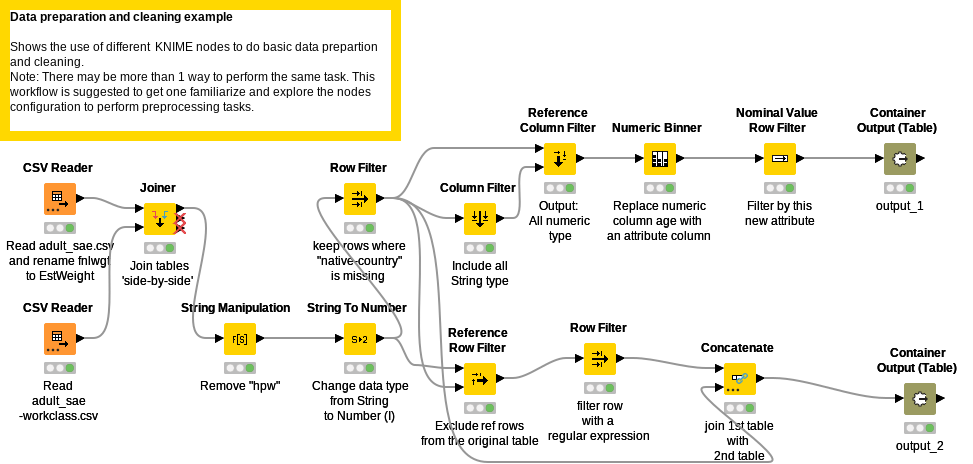

Wall time: 69.3 ms


In [5]:
%%time
with knime.Workflow(workflow_dir_list[1]) as wf:
    wf.display_svg()

## Reading and executing KNIME workflows in python
<a id='read_exec'></a>
The `knime.Workflow` function takes in the full workflow path directory and generates an workflow object `wf`. Other than being able to display the graphical workflow, the following commands are of interest to us:

1. `wf.execute()` executes the workflow
2. `wf.display_svg()` displays the svg image of the workflow
3. `wf.data_table_outputs` returns a list of panda dataframes which are collected from the `Container Output (Table)` node, after executing the workflow in python.
4. `SVG(wf._adjust_svg())` saves the svg file in `IPython.core.display.SVG` format. Needs additional package for it to be saved to file.

**Note:** It is important that the KNIME workflow is not open in KNIME, otherwise it will return an error message which says: `Workflow is locked by another KNIME instance`.

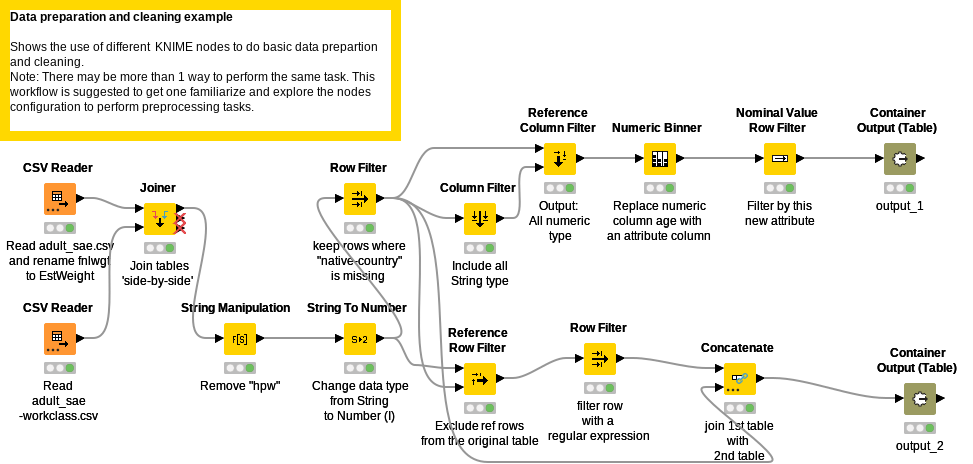

Wall time: 17.1 s


In [6]:
%%time
with knime.Workflow(workflow_dir_list[1]) as wf:
    wf.display_svg()                       # displays svg graphical workflow
    wf.execute()                           # executes the workflow
    output_tables = wf.data_table_outputs  # saves all the data collected in the COT nodes as a list of pandas dataframe 
    img = SVG(wf._adjust_svg())            # saves svg graphical workflow in img (for saving image to local drive)


In the workflow above, we see that there are two COT nodes connected to the last node of the lab task. When the COT node is executed, the data from the previous node is piped into it. In python, it is retrieved using the `wf.data_table_outputs`, and we have saved it as `output_tables`. As there are two COT nodes, this means `output_tables` is a list of two pandas dataframe.

**Note:** An issue with `wf.data_table_outputs` is while we have all the tables in a list, there is no good way of identifying which table in the list matches to the output of a particular COT node. Through observation, it is suspected that the ordering is based on the order which the COT nodes are dragged into the workspace. This is an aspect we do not have control over; we cannot get user to drag the COT nodes in a particular order. Thus we would require a way to identify which dataframe correspond to data output of which COT node.

A possible way to do this identification can to be use other information like number of rows, number of columns to identify the outputs. However this method is tedious as more code is needed to do the checks and grading time would possibly take longer.

In [7]:
len(output_tables)

2

In [8]:
output_tables[0].head()

,age,EstWeight,education-num,capital-gain,capital-loss,hours-per-week(new)
0,middle,121772,11,0,0,40
1,middle,84154,10,0,0,38
2,middle,293936,4,0,0,40
3,middle,117747,9,0,1573,35
4,middle,153141,9,0,0,40


In [9]:
output_tables[1].head()

,age,EstWeight,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,workclass,hours-per-week(new)
0,53,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40hpw,United-States,<=50K,Private,40
1,49,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16hpw,Jamaica,<=50K,Private,16
2,34,245487,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,Amer-Indian-Eskimo,Male,0,0,45hpw,Mexico,<=50K,Private,45
3,38,28887,11th,7,Married-civ-spouse,Sales,Husband,White,Male,0,0,50hpw,United-States,<=50K,Private,50
4,35,76845,9th,5,Married-civ-spouse,Farming-fishing,Husband,Black,Male,0,0,40hpw,United-States,<=50K,Federal-gov,40


## Implementation of customised function to identify output tables
<a id='customised_functions'></a>

The issue of identifying which pandas dataframe from `output_tables` matches to which data from COT node with annotation `output_1` and `output_2` respectively is important for the grading process. This particular functionality have been requested multiple times by other users. The developers have acknowledged this request as an enhancement but the functionality still remains to be implemented although the requests were made 2-3 years ago.

After understanding the code in `knime.py`, this enhancement has been implemented by a custom `data_COT_annotation` function. This function collects the annotations of the COT nodes in the same order as the dataframes are collected from the COT nodes. This we are able to map the dataframes collected from the COT nodes to its respective node annotation.

Thus for us to use computer-assisted grading of KNIME lab assignments we require:
1. Connection of outputs to be graded to COT nodes
2. Annotations of COT nodes for identification

The conditions above are easily achieved by providing clear instructions on the submission format. With access to annotations of the COT nodes, we can easily identify the output data to the respective nodes.

In [10]:
len(output_tables)

2

In [11]:
wf.COT_annotation

['output_1', 'output_2']

In [12]:
wf.file_reader_data_path

['D:\\Teaching\\SAE\\BB\\Datasets\\Chapter05\\adult_sae.csv',
 'file:/D:/Teaching/SAE/BB/Datasets/Chapter05/adult_sae-workclass.csv']

## Storing the outputs of each workflow as a dictionary
<a id='store-as-dic'></a>

Storing our output tables as a dictionary is more convenient, thus we use the function below to return a dictionary where the key is the annotation and the value is the output dataframe.

In [13]:
def collect_workflow_outputs(path_to_knime_workflow):
    """
    Collect all the outputs of the workflow in the provided path to a KNIME workflow.
    Returns a dictionary where (key,value) = (node annotation,output table)
    """
    wf = knime.Workflow(path_to_knime_workflow)
    wf.execute()
    return dict(zip(wf.COT_annotation,wf.data_table_outputs))

We store the answers of the model completed workflow in the dictionary `model_output` which will be used later in the computer assisted grading.

In [14]:
model_output = collect_workflow_outputs(workflow_dir_list[1])

## Grading a workflow
<a id='grade-a-workflow'></a>

The grading of a submitted workflow is more involved as it requires us to consider the various possibilities which we want to be able to detect in the submission. After some consideration, it is natural to adopt a *top down approach* for this type of grading. Below is a initial list with increasing granularity:

Implemented:
- **Incorrect COT node annotation**: annotation of COT node do not match what was specified in the instructions
- **Number of missing submissions**: dataframes which are missing for a submission
- **Number of missing variables**: variables which are missing for an output

Not started:
- **Incorrect data types**: based on the matched variables, datatypes which are incorrect
- **Incorrect number of rows**: number of rows do not match
- **Incorrect data values for a variable**: data for a variable does not match


The core grading principle of this computer assisted grading is to purely highlight what is the differences in the submitted output when referenced against the expected output. This would also suggest that any scoring of a lab submission is done by deduction of marks based on the number of missing (learning) objectives.

**Note:** There are certain scenarios which we might be able to imply explicitly the missing steps but this might not be true for all scenarios thus we do not aim for such an advanced level of computer assisted grading. 

## Grading a workflowV2

The grading of a submitted workflow is more involved as it requires us to consider the various possibilities which we want to be able to detect in the submission. After some consideration, it is natural to adopt a *top down approach* for this type of grading. Below is a initial list with increasing granularity:


- Check COT annotations
- Compare dataframes in dictionaries
- Compare variable names and number of variables in dataframe
- Compare variable datatypes
- Compare dataframe by columns

The core grading principle of this computer assisted grading is to purely highlight what is the differences in the submitted output when referenced against the expected output. This would also suggest that any scoring of a lab submission is done by deduction of marks based on the number of missing (learning) objectives.

**Note:** There are certain scenarios which we might be able to imply explicitly the missing steps but this might not be true for all scenarios thus we do not aim for such an advanced level of computer assisted grading. 

Here we look at how the computer-assisted grading process works for the complete workflow submission `s11006381_complete`. 

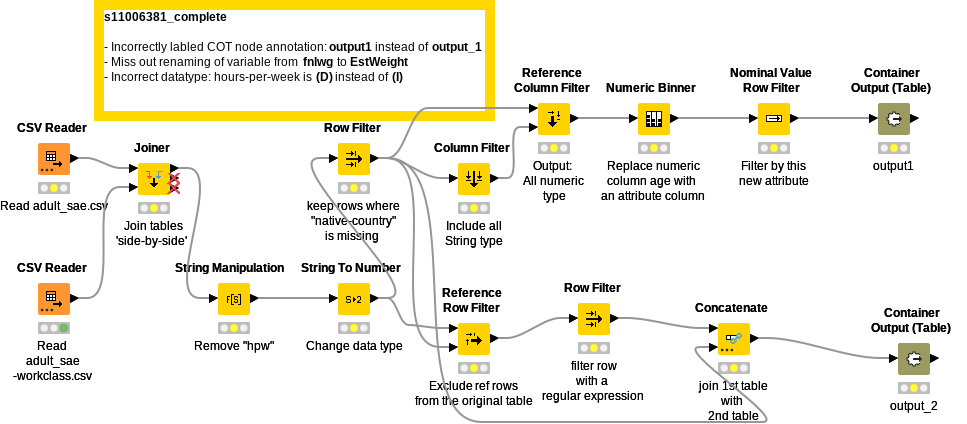

Wall time: 176 ms


In [38]:
%%time
with knime.Workflow(workflow_dir_list[3]) as wf_complete:
    wf_complete.display_svg()

The submitted answers is collected with the `collect_workflow_outputs` function which returns a dictionary saved as `complete_output`.

In [56]:
%%time
complete_output = collect_workflow_outputs(workflow_dir_list[3])

Wall time: 18.9 s


In [57]:
for d in complete_output:
    print(d)
    print(complete_output[d].head())

output1
      age  education-num  capital-gain  capital-loss  hours-per-week(new)
0  middle             11             0             0                 40.0
1  middle             10             0             0                 38.0
2  middle              4             0             0                 40.0
3  middle              9             0          1573                 35.0
4  middle              9             0             0                 40.0
output_2
   age  fnlwgt education  education-num         marital-status  \
0   53  234721      11th              7     Married-civ-spouse   
1   49  160187       9th              5  Married-spouse-absent   
2   34  245487   7th-8th              4     Married-civ-spouse   
3   38   28887      11th              7     Married-civ-spouse   
4   35   76845       9th              5     Married-civ-spouse   

          occupation   relationship                race     sex  capital-gain  \
0  Handlers-cleaners        Husband               Black    Ma

#### Check COT annotations
<a id='check_cot'></a>

As we rely on the COT node annotations to help us label the dataframes, we first need to check that the COT annotations match the expected annotations.

[back to top](#top)

In [58]:
def compare_COT_annotation(d1,d2):
    """
    Compares the annotation of the COT nodes based on the dictionaries 
    from `collect_workflow_outputs`. The dictionary d1 is the reference
    which d2 is compared against. 
    
    Note that this function does not commutes.
    
    Args:
        d1, d2: dictionaries of form {node_annotation: dataframe_from_COT}.
    Returns:
        missing_ann: list of annotations of d1 which are not in d2.
        foreign_ann: list of annotations of d2 which are not in d1.
    """
    foreign_ann = []
    missing_ann = []
    for k in d1:
        if not (k in list(d2.keys())):
            missing_ann.append(k)
    for k in d2:
        if not (k in list(d1.keys())):
            foreign_ann.append(k)
    return missing_ann, foreign_ann    

In this scenario, we have `output_1` and `output1` returned as missing and foreign annotations respectively. As we rely heavily on the keys of the dictionary to compare the dataframes, the ideal scenario is when there are no missing and foreign annotations.

**Consideration:** We need to decide if we will accept wrong annotations. Accepting them will require manual work for the grader which defeats the computer-assisted grading motivation.

**Note:** Even if the COT annotations match, it is the students' responsibility to annotate the COT nodes correctly, i.e. label the COT node which produces the first output `output_1` and not `output_2`. Labeling the first output `output_2` is similar to writing the answer for question 1 in the blank for question 2.

In [59]:
compare_COT_annotation(model_output,complete_output)

(['output_1'], ['output1'])

We do a manual correction of the annotation here to progress to other grading concerns.

In [60]:
complete_output['output_1'] = complete_output['output1']
del complete_output['output1']

In [61]:
complete_output.keys()

dict_keys(['output_2', 'output_1'])

#### Compare dataframes in dictionaries
<a id='compare_df_dic'></a>
The pandas package provides the `.equal()` comparison function to check if two dataframe contains the same element. Specifically it checks if they have the same shape and elements. NaNs in the same location are considered equal. The row/column index **do not** need to have the same type, as long as the values are considered equal. Corresponding data in the columns must be of the **same dtype**.

**Note:** for two dataframes to be equal, the columns need to be in the same order for equality to hold. For example:
```
a = pd.DataFrame({1: [10], 2: [20]})
b = pd.DataFrame({2: [20], 1: [10]})
a.equals(b)
```
returns `False`.

Thus the variable namings need to be separately checked. 

[back to top](#top)

In [62]:
def compare_dict_df(d1,d2):
    """
    Checks equality the dataframes in the dictionaries d1, d2 based
    on the keys using the `.equals()` pandas function. The dictionary d1 
    is the reference which d2 is compared against. 
    
    Note that this function does not commutes.
    
    Args:
        d1, d2: dictionaries of form {node_annotation: dataframe_from_COT}.
    Returns:
        score: a number in [0,1] to indicate the fraction of equal dataframes.
        err_df: list of output annotations with not equal dataframe.
    """
    n = len(list(d1.keys()))
    c = 0
    err_df = []
    for k in d2:
        if d2[k].equals(d1[k]):
            c += 1
        else:
            err_df.append(k)
    score = c/n
    return score, err_df

In the experiments below, the difference in the datatype for `hours-per-week(new)` lead both dataframes `output_1` and `output_2` of `complete_output` to be difference from those in `model_output`. When we test the `model_output` with itself we get a perfect score.

In [63]:
compare_dict_df(model_output,complete_output)

(0.0, ['output_2', 'output_1'])

In [64]:
compare_dict_df(model_output,model_output)

(1.0, [])

Before we rush over to check the datatypes, we check the variable names and use the results to guide us in checking the datatypes.

#### Compare variable names and number of variables in dataframe
<a id='compare_varnames'></a>
The `.equals()` function do not take into consideration of the variable names. Thus there can be instances that a rename variable task is not performed although the other steps are done. This is addressed by the compare variable names function below. To illustrate the scenario, the `s11006381_complete` misses out on renaming of variable `fnlwg` to `EstWeight` which is visible in the dataframe from `output_2`.

[back to top](#top)

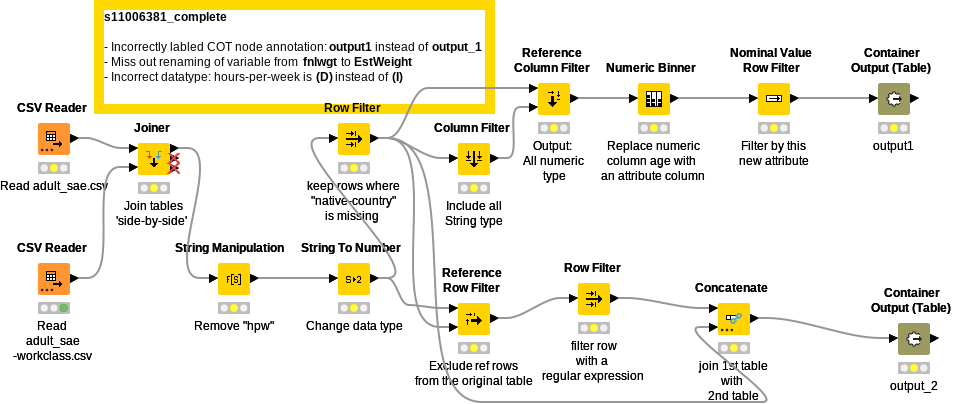

Wall time: 88 ms


In [65]:
%%time
with knime.Workflow(workflow_dir_list[3]) as wf_complete:
    wf_complete.display_svg()

In [66]:
def compare_varnames(df1, df2):
    """
    Compares the variable names of the dataframes.
    The dataframe df1 is the reference which df2 is compared against. 
    
    Args:
        df1, df2: dataframes extracted from COT nodes.
    Returns:
        missing_vars: list of variable names which are in df1 but not in df2.
        matched_vars: list of variable names which are in df1 and also in df2.
        score: a number in [0,1] to indicate the fraction of correctly matched variable names.
    """
    df1_col = df1.columns
    df2_col = df2.columns
    missing_vars = []
    foreign_vars = []
    for varname in df1_col:
        if not (varname in df2_col):
            missing_vars.append(varname)
    for varname in df2_col:
        if not (varname in df1_col):
            foreign_vars.append(varname)
    return missing_vars, foreign_vars, (len(df1_col)-len(missing_vars))/len(df1_col)

The design of the `compare_varnames` is will return the expected variable names which are missing and also the foreign variable names which are observed. 

For the lab exercise, we require the student to rename the `fnlwgt` variable to `EstWeight`. When the renamed is not done, we will expect to see the variable `EstWeight` missing, and `fnlwgt` 

In [67]:
missing_var, foreign_var, _ = compare_varnames(model_output['output_2'],complete_output['output_2'])

In [68]:
print(missing_var)
print(foreign_var)

['EstWeight']
['fnlwgt']


When the variable names matches, empty lists will be returned

In [69]:
compare_varnames(model_output['output_2'],model_output['output_2'])

([], [], 1.0)

#### Compare variable datatypes
<a id='compare_dtypes'></a>
The comparison of variable names allow us to identify the matched variables. The datatypes will be checked for the list of matched variables names. This would require extracting matched variables of the dataframe.

[back to top](#top)

In [88]:
def compare_dtypes(df1, df2, missing_var, foreign_var):
    """
    
    
    Args:
        df1: dataframe output which is reference
        df2: dataframe output from a submission
        missing_var: list of missing variables from df1
        foreign_var: list of foreign variables in df2
    
    Returns:
        var_incorrect_dtype: list of 3-tuple of the form (variable_name, expected_dtype, actual_dtype)
    """
    df1 = df1.drop(columns=missing_var)
    df2 = df2.drop(columns=foreign_var)
    var_incorrect_dtype = []
    for v in df1.columns:
        if not (df1.dtypes[v] == df2.dtypes[v]):
            var_incorrect_dtype.append((v,df1.dtypes[v],df2.dtypes[v]))
    return var_incorrect_dtype

In [89]:
compare_dtypes(model_output['output_2'],complete_output['output_2'],missing_var,foreign_var)

[('hours-per-week(new)', dtype('int64'), dtype('float64'))]

#### Compare dataframe by columns
<a id='compare_df_col'></a>


[back to top](#top)

In [99]:
def compare_df_col(df1, df2, missing_var):
    """
    
    """
    err_data_col = []
    
    for v in df1.drop(columns=missing_var).columns:
        if not df1[v].equals(df2[v]):
            err_data_col.append(v)
    return err_data_col

In [100]:
compare_df_col(model_output['output_2'],complete_output['output_2'],missing_var)

['hours-per-week(new)']

# Continue
<a id='continue'></a>

#### Compare variable names

#### Compare variable datatypes

# Resource below

A simple illustration of collecting the output data and annotation for multiple workflows which roughly takes **43 seconds**. Note that `l` is a list of dictionaries; each dictionary contains all the COT node annotations and COT node data.

In [ ]:
%%time
l = []
for i in workflow_dir_list[3:7]:
    print(i)
#     d = collect_workflow_outputs(i)
    l.append(collect_workflow_outputs(i))

print(len(l))    

It is known that the workflow `s11006381_complete` does exactly what is done in the lab and should have the same answer as the completed workflow provided by the MC.

In [ ]:
def compare_COT_annotation(d1,d2):
    """
    Compares the annotation of the COT nodes based on the dictionaries 
    from `collect_workflow_outputs`. The dictionary d1 is the reference
    which d2 is compared to. Note that this function does not commutes.
    
    Args:
        d1, d2: dictionaries of form {node_annotation: dataframe_from_COT} 
    Returns:
         list of annotations of d2 which are not in d1.
    """
    diff_ann = []
    for k in d2:
        if not (k in list(d1.keys())):
            diff_ann.append(k)
    return diff_ann    

In [ ]:
# comparing COT annotations of multiple submissions
for i in l:
    diff = compare_COT_annotation(model_ans,i)
    print(diff)

In [ ]:
# comparing COT annotations of multiple submissions
for i in l:
    diff = compare_COT_annotation(i,model_ans)
    print(diff)

In [ ]:
def compare_dict_outputs(d1,d2):
    n = len(list(d1.keys()))
    c = 0
    for k in d2:
        if d2[k].equals(d1[k]):
            c += 1
    return c/n 

In [ ]:
# comparing dic of multiple submissions
for i in l:
    try:
        s = compare_dict_outputs(model_ans,i)
        print(s)
    except:
        print('Err')
    

In [44]:
def compare_varnames(df1, df2):
    """
    Compares the variable names of the dataframes.
    The dataframe df1 is the reference which df2 is compared against. 
    
    Args:
        df1, df2: dataframes extracted from COT nodes.
    Returns:
        missing_vars: list of variable names which are in df1 but not in df2.
        matched_vars: list of variable names which are in df1 and also in df2.
        score: a number in [0,1] to indicate the fraction of correctly matched variable names.
    """
    df1_col = df1.columns
    df2_col = df2.columns
    missing_vars = []
    matched_vars = []
    for varname in df1_col:
        if not (varname in df2_col):
            missing_vars.append(varname)
        else:
            matched_vars.append(varname)
    assert len(missing_vars) + len(matched_vars) == len(df1_col)
    return missing_vars, matched_vars, (len(df1_col)-len(missing_vars))/len(df1_col)

The graphical display of the submitted workflow tells us that the workflow is not completed; only one of the path is done. The graphical display also shows the state of the workflow which the submission is saved; if some nodes are not configured, have errors or warnings, it is shown.

### Rename variable task

Below is an example of a submission where the renaming of the variable is not done.

In [ ]:
sub_tables[0].columns

In [ ]:
secG.columns

We can compare the columns names

In [ ]:
x=np.where((stu_tables[0].columns == secG.columns) == True)[0]

In [ ]:
x

In [ ]:
stu_tables[0][x]

In [ ]:
def check_var_names(df, stu_df):
    idx = np.where((stu_df.columns == df.columns) == False)[0]
    score = np.average(stu_df.columns == df.columns)
    print("The following variables have not been renamed:\n{}".format(stu_df.columns[idx]))
    return stu_df.columns[idx], score

In [ ]:
v,s = check_var_names(secG,stu_tables[0])

In [ ]:
secG.dtypes['hours-per-week(new)']

In [ ]:
def dtype_check(df, stu_df,cols):
    n =
    for v in cols:
        df.dtypes[v] == stu_df.dtypes[v]
    

In [ ]:
secG.dtypes

In [ ]:
stu_tables[0].dtypes

Running a student's workflow

In [ ]:
with knime.Workflow(workflow_list[5]) as stu_wf:
    stu_wf.execute()
    stu_wf.display_svg()
    stu_tables = stu_wf.data_table_outputs
    stu_img = SVG(stu_wf._adjust_svg())


In [ ]:
stu_tables = stu_wf.data_table_outputs

In [ ]:
secG.equals(stu_tables[0])

In [ ]:
secG.dtypes

In [ ]:
stu_tables[0].dtypes

In [ ]:
secG.columns == stu_tables[0].columns

In [ ]:
secG.compare(stu_tables[0])

In [ ]:
stu_tables[0].dtypes == secG.dtypes

In [ ]:
np.where((np.array(secG.dtypes) == np.array(stu_tables[0].dtypes))==False)

In [ ]:
list(secG.dtypes) == list(stu_tables[0].dtypes)

In [ ]:
stu_tables[0]

In [ ]:
type(img)

### Saving output data
<a id='save_data'></a>
Here, data of the COT node labeled `section G output` is found as the first dataframe in `output_tables`.

Saving of the pandas dataframe to our local directory is done using the `to_pickle` function. The saved dataframe will be stored with a `.pkl` extension.

As an illustration, we save `output_tables[0]` to `secG.pkl`, and it can be found in the project directory immediately.

In [ ]:
output_tables[0].to_pickle('secG.pkl')
del output_tables
os.listdir()

We can read the pickled dataframes back into our environment with `pd.read_pickle`. With these dataframes, we can use python to help us check if the workflow submitted by our students are correct when compared to our model answer.

In [ ]:
output_1 = pd.read_pickle("secG.pkl")
output_1.head()